In [1]:
import sys
sys.path.append("../")
from utils.datasets import Datasets
from utils.knowledgedistillationtriplet import KnowledgeDistillationTriplet
from utils.save_results import save_info, plot_graph
from utils.networks import *
from utils.kldivloss import KLDivLoss

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

import numpy as np

f:\university\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED = 1
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

#Dataset config
DATASET = 'CIFAR10'
DATASET_DIR = './dataset'
BATCH_SIZE = 100
NUM_WORKERS = 2

#Optimizer config
WEIGHT_DECAY = 0.001
LEARNING_RATE = 0.01
GAMMA = 0.1
STEPS = 30

#Training config
EPOCH = 100

# KD config
LAMBDA = 1.0

# Triplet config
MARGIN = 5.0
TriLAMBDA = 2.0

In [3]:
torch.cuda.manual_seed_all(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
train_trans = transforms.Compose(
    [
        #transforms.RandomCrop(32, padding=4),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #transforms.Normalize((0.485, 0.456, 0.406),
        #                     (0.229, 0.224, 0.225)),
    ],
)
test_trans = transforms.Compose(
    [
        transforms.ToTensor(),
        #transforms.Normalize((0.485, 0.456, 0.406),
        #                     (0.229, 0.224, 0.225)),
    ],
)
instance_datasets = Datasets(
    DATASET,
    BATCH_SIZE,
    NUM_WORKERS,
    transform=train_trans,
    test_transform=test_trans,
    dataset_dir=DATASET_DIR,
)
data_sets = instance_datasets.create(
    [
        "KDTriplet",
    ],
)

trainloader = data_sets[0]
testloader = data_sets[1]
classes = data_sets[2]
based_labels = data_sets[3]
input_channels = data_sets[4]
trainset = data_sets[5]
testset = data_sets[6]

Dataset : CIFAR10
set train data
Files already downloaded and verified
set test data
Files already downloaded and verified


In [5]:
model = Net(
    input_channels=input_channels,
    num_classes=len(classes),
).to(device)
#teacher = torch.load("./teacher_model.pth").to(device)

teacher = Net(
    input_channels=input_channels,
    num_classes=len(classes),
).to(device)

optimizer = optim.SGD(model.parameters(),
                      lr=LEARNING_RATE,
                      momentum=0.9,
                      weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer,
                                      step_size=STEPS,
                                      gamma=GAMMA)

soft_criterion = KLDivLoss(reduction='batchmean')
hard_criterion = nn.CrossEntropyLoss()
triplet_loss = nn.TripletMarginLoss(margin=MARGIN)

kdt = KnowledgeDistillationTriplet(
    model,
    teacher,
    optimizer,
    soft_criterion,
    hard_criterion=hard_criterion,
    triplet_loss=triplet_loss,
    lam=LAMBDA,
    triplet_lam=TriLAMBDA,
)

In [6]:
losses, soft_losses, hard_losses, triplet_losses, accuracies = kdt.fit(
    EPOCH,
    trainloader,
    testloader,
    scheduler=scheduler,
    device=device,
)

epoch:1


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:59<00:00,  8.36it/s]


Training data results-----------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:26<00:00, 18.55it/s]


mean_loss=0.24206249507904054, mean_soft_loss=0.0018741202142834664, mean_hard_loss=0.04011435614109039, triplet_loss=0.10003700923919678, acc=0.32224
Test data results---------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.22it/s]

mean_loss=0.24235412483215332, mean_soft_loss=0.0018489078119397163, mean_hard_loss=0.04014108486175537, triplet_loss=0.1001820662498474, acc=0.3225


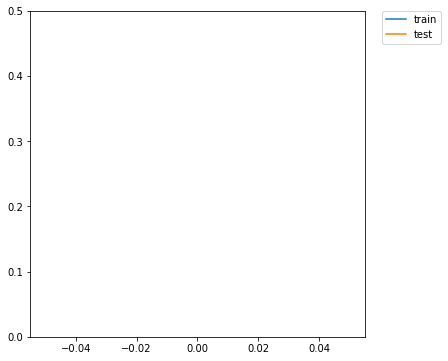

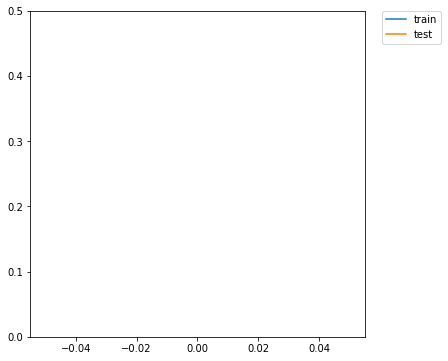

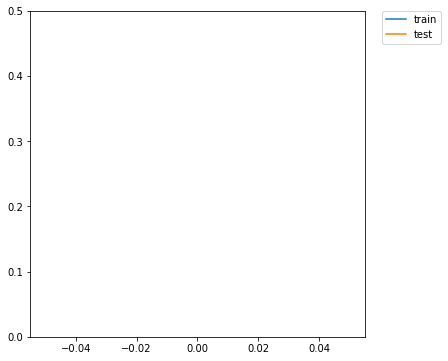

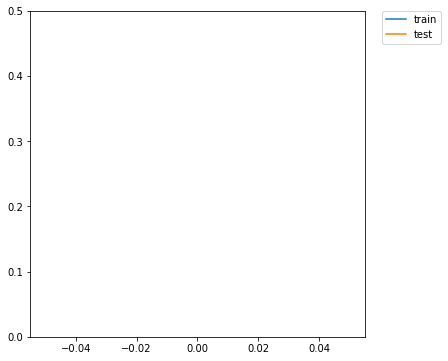

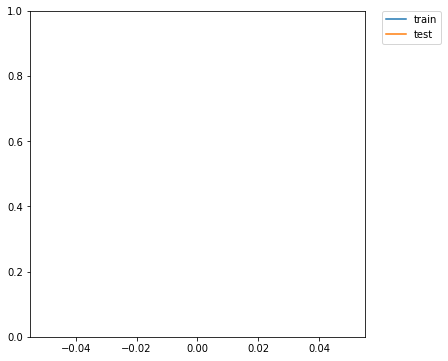

In [7]:
plot_graph(losses, 0.5, filename="loss")
plot_graph(soft_losses, 0.5, filename="soft_loss")
plot_graph(hard_losses, 0.5, filename="hard_loss")
plot_graph(triplet_losses, 0.5, filename="triplet_loss")
plot_graph(accuracies, 1, filename="accuracy")

In [8]:
info = {}
info["DATASET"] = DATASET
info["Learnign_rate"] = LEARNING_RATE
info["Weight_decay"] = WEIGHT_DECAY
info["EPOCH"] = EPOCH
info["STEPS"] = STEPS
info["GAMMA"] = GAMMA
info["Model"] = model
info["soft_Criterion"] = soft_criterion
info["hard_Criterion"] = hard_criterion
info["triplet_loss"] = triplet_loss
info["Optimizer"] = optimizer
info["train_loss"] = losses["train"][-1]
info["test_loss"] = losses["test"][-1]
info["train_triplet_loss"] = triplet_losses["train"][-1]
info["test_triplet_loss"] = triplet_losses["test"][-1]
info["train_acc"] = accuracies["train"][-1]
info["test_acc"] = accuracies["test"][-1]

In [9]:
save_info(info, DATASET+"_info")

In [10]:
torch.save(model.cpu().state_dict(), 'student_param.pth')
torch.save(model.cpu(), 'student_model.pth')